### Written by  [Gabriel Borges Pinheiro](https://www.github.com/gabrielbopi) & Wissam Melo

In [1]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
%matplotlib inline

# This import registers the 3D projection, but is otherwise unused.
#from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

#### Creating the test environment

In [2]:
def bases(D, x, y, alt=15):
    num_x = int(x/D)
    num_y = int(y/D)
    total = num_x*num_y
    n = np.array([])
    for i in range(num_y):
        for j in range(num_x):
            n = np.append(n, np.array([(j*D)+(D/2),(i*D)+(D/2),alt])) 
        
    return total, n.reshape(total,3)

def usuário(n, x, y):
    UE = np.array([])
    for i in range(n):
        UE = np.append(UE,np.array([x*np.random.random(),y*np.random.random(),1.5]))
    return UE.reshape(n,3)

In [3]:
def BSs_per_UE(BS, UE, total):
    endereços = []

    for n in range(num_ue):
        BS_UE = np.array([])
        conectadas = 0
        for i in range(total):
            dist = np.linalg.norm(BS[i]-UE[n])
            if dist <= 50:
                conectadas += 1
                BS_UE = np.append(BS_UE, BS[i])
        BS_UE = np.append(BS_UE, 0)
        endereços = np.append(endereços,BS_UE)
  
    # using list comprehension + zip() + slicing + enumerate() 
    # Split list into lists by particular value 
    size = len(endereços) 
    idx_list = [idx + 1 for idx, val in enumerate(endereços) if val == 0] 
    res = [endereços[i: j] for i, j in zip([0] + idx_list, idx_list + ([size] if idx_list[-1] != size else []))]
    
    for i in range(len(res)):
        indices = np.where(res[i]==0)
        res[i] = np.delete(res[i], indices)
        res[i] = res[i].reshape(int((res[i].shape[0])/3),3)
    res = np.array(res)
    return res

In [4]:
def UEs_per_BS(BS, UE, total):
    positions = []

    for n in range(total):
        BS_UE = np.array([])
        conectados = 0
        for i in range(len(UE)):
            dist = np.linalg.norm(BS[n]-UE[i])
            if dist <= 50:
                conectados += 1
                BS_UE = np.append(BS_UE, UE[i])
        BS_UE = np.append(BS_UE, 0)
        positions = np.append(positions,BS_UE)
    
    # using list comprehension + zip() + slicing + enumerate() 
    # Split list into lists by particular value 
    size = len(positions) 
    idx_list = [idx + 1 for idx, val in enumerate(positions) if val == 0]
    antenna = [positions[i: j] for i, j in zip([0] + idx_list, idx_list + ([size] if idx_list[-1] != size else []))] 

    for i in range(len(antenna)):
        indices = np.where(antenna[i]==0)
        antenna[i] = np.delete(antenna[i], indices)
        antenna[i] = antenna[i].reshape(int((antenna[i].shape[0])/3),3)
    return antenna

##### Generating BSs and UEs

In [5]:
#Espaçamento entre cada BS
gap_bs = 50 #m

total,BS = bases(gap_bs, 200, 100)

In [6]:
num_ue = 3
UE = usuário(num_ue, 200, 100)
UEs_per_BS(BS, UE, total)

[array([[38.365955  , 65.52438266,  1.5       ]]),
 array([], shape=(0, 3), dtype=float64),
 array([], shape=(0, 3), dtype=float64),
 array([[178.73239247,  48.84151707,   1.5       ]]),
 array([[38.365955  , 65.52438266,  1.5       ]]),
 array([[ 38.365955  ,  65.52438266,   1.5       ],
        [101.58129551,  73.4788802 ,   1.5       ]]),
 array([[101.58129551,  73.4788802 ,   1.5       ]]),
 array([[178.73239247,  48.84151707,   1.5       ]])]

#### Calculating the parameters

In [7]:
def db(X):
    return 10 * np.log10(np.abs(X))
def inv_db(X):
    return 10**(X/10)
def dbm(X):
    return 10 * np.log10(np.abs(X)/(1e-3))
def inv_dbm(X):
    return (1e-3) * 10**(X/10)

In [8]:
def β_channel(D):
    """
    Returns the 
    """
    #Carrier frequency (LTE band 7)
    f = 2.6e9
    #Wavelength
    λ = 3e8/f
    R = D
    #Linear pathloss
    L_lin =  (λ/(4*np.pi*R))**2
    β = L_lin
    return β

def rand_channel(D, N):
    """
    Returns the channel
    """
    β = β_channel(D)
    ampl = np.sqrt(β)/2
    h = (np.random.randn(N) + 1j*np.random.randn(N)) * ampl
    return h

def channel_user2(num_ue,numBS,nAntennas,UEpos,BSpos,UEs_antenna):
    """
    Retorna uma matriz 3D, onde h[UE][BS]{stream}
    """
    H = np.zeros((num_ue,numBS,nAntennas),dtype=complex)

    for ii in range(numBS):
        for jj in range(UEs_antenna[ii].shape[0]):
            user = np.argmin(np.sum(np.abs(UEs_antenna[ii][jj] - UEpos),axis=1))
            R = np.linalg.norm(BSpos[ii] - UEs_antenna[ii][jj]) 
            H[int(user)][ii] = rand_channel(R, nAntennas)

    return H

def powerUE(num_ue, total, UEpos,UEs_antenna, P_dBm):
    p = np.zeros(num_ue)
    for i in range(total):
        UE_BS = UEs_antenna[i].shape[0]
        for j in range(UEs_antenna[i].shape[0]):
            user = np.argmin(np.sum(np.abs(UEs_antenna[i][j] - UEpos),axis=1))
            p[int(user)] =  p[int(user)] + (inv_dbm(P_dBm)/int(UE_BS))
    return dbm(p)

def get_beamforming(h, num_ue, total, P_dBm):
    p = inv_dbm(P_dBm)
    v = np.zeros((num_ue,total*N), dtype = 'complex_')
    for i in range(num_ue):
        v[i] = np.sqrt(p[i])*(np.conjugate(h[i])/np.linalg.norm(h[i]))
        
    return v

def get_beamforming2(h, num_ue, total, P_dBm):
    """
    Retorna o beamforming de um canal h, onde v[UE][BS]{stream}
    """
    p = inv_dbm(P_dBm)
    v = np.zeros((num_ue,total,N), dtype = 'complex_')
    for k in range(num_ue):
        for n in range(total):
            norm_Hkn = np.linalg.norm(h[k][n])
            if norm_Hkn != 0:                          
                v[k][n] = np.sqrt(p[k])*np.conjugate(h[k][n])/norm_Hkn
    return v

In [9]:
P_dBm = 40
#Numero de antenas no arranjo
N = 5
num_BS = 8
num_ue = 3
UE = usuário(num_ue, 200, 100)
UEs_antenna = UEs_per_BS(BS, UE, total)
P_dBm = powerUE(num_ue, num_BS, UE,UEs_antenna, P_dBm)
P_dBm

array([40.        , 45.44068044, 43.97940009])

In [10]:
def vectorize(H, num_ue, total, N):
    h = np.zeros((num_ue, N*total), dtype ='complex_')
    for i in range(num_ue):
        h[i] = H[i].reshape(N*total)
    return h

In [11]:
#Band of signal
B = 1e6 #Hz
#Power of noise (-127dBm is average)
N0 = inv_dbm(-127)
σ = B*N0

In [12]:
def sinr(h, V, j, σ):
    
    num = np.abs(V[j].transpose()@h)**2
    den = np.zeros(num.shape)
    for x in range(V.shape[0]):
        if x!=j:
            den += np.abs(V[x].transpose()@h)**2
    return (num/(den+σ))

def sinr_mc(num_ue, N, BS, P_dBm):
    """
    Gerar os canais, Com mesma BS e gerando diferentes UE calculando H,V,sinr e C()
    """
    total = BS.shape[0]
    UE = usuário(num_ue, 200, 100)
    UEs_antenna = UEs_per_BS(BS, UE, total)
    P_dBm = powerUE(num_ue, total, UE,UEs_antenna, P_dBm)
    H = channel_user2(num_ue,total,N,UE,BS,UEs_antenna)
    H = vectorize(H, num_ue, total, N)
    V = get_beamforming(H, num_ue, total, P_dBm)
    S = np.zeros(len(UE))
    for i in range(len(UE)):
        S[i] = sinr(H[i], V, i, σ)
    C = np.sum(np.log2(S+1))
    return C

def sem_mc(num_ue, N, BS, P_dBm):
    """
    Gerar os canais, Com mesma BS e gerando diferentes UE calculando H,V,sinr e C()
    """
    total = BS.shape[0]
    UE = usuário(num_ue, 200, 100)
    UEs_antenna = [UE,UE,UE,UE,UE,UE,UE,UE]
    P_dBm = powerUE(num_ue, total, UE,UEs_antenna, P_dBm)
    H = channel_user2(num_ue,total,N,UE,BS,UEs_antenna)
    H = vectorize(H, num_ue, total, N)
    V = get_beamforming(H, num_ue, total, P_dBm)
    S = np.zeros(len(UE))
    for i in range(len(UE)):
        S[i] = sinr(H[i], V, i, σ)
    C = np.sum(np.log2(S+1))
    
    return C

In [13]:
mc = 300
n = [1,2,4,6,8,10,12,14,16,18,19,20,22,24]#,26,28,30,32,35,38,40,52,64,80,100]#,128]
us = [1,2,8,16,24,32,40,45,50,55,60]

In [14]:
def cdf(C):
    hist, bins = np.histogram(C, bins=20)
    pdf_C = hist/np.sum(hist)
    cdf_C = np.cumsum(pdf_C)
    return cdf_C, pdf_C, bins

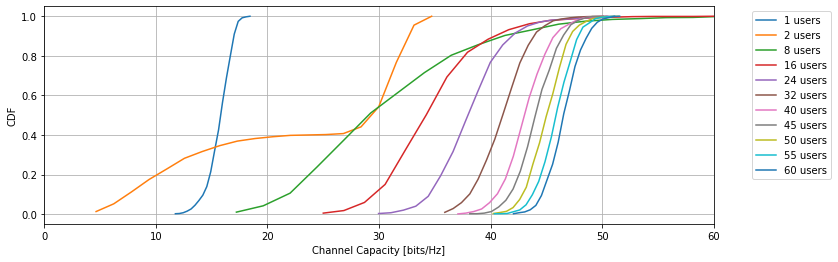

In [32]:
plt.figure(figsize=(12,4))
AVG = np.array([])
for i in range(len(us)):
    C = np.zeros(mc)
    for j in range(mc):
        np.random.seed(j)
        C[j] = sinr_mc(us[i], N, BS, P_dBm)
    CDF, PDF, BINS = cdf(C)
    #AVG = np.append(AVG, avg)
    label = ('{} users'.format(us[i]))
    plt.plot(BINS[1::], CDF, label=label)
    #print("n - " + str(us[i]))
plt.ylabel("CDF")
plt.xlabel("Channel Capacity [bits/Hz]")
plt.xlim(0,60)
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.grid()

In [14]:
def cdf(C):
    C = np.sort(C)
    average_C = np.mean(C)
    std_C = np.std(C)
    cdf_C = norm.cdf(C, loc=average_C, scale=std_C)
    return cdf_C, average_C

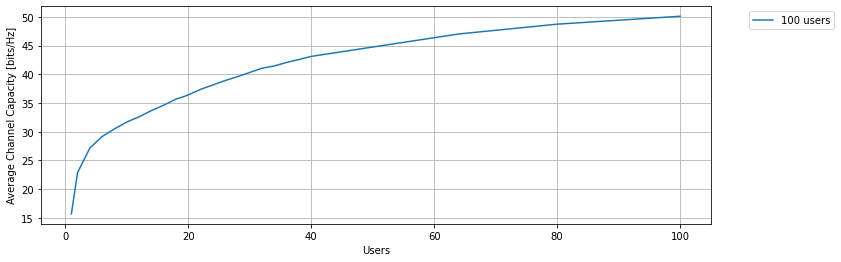

In [34]:
plt.figure(figsize=(12,4))
AVG = np.array([])
for i in range(len(n)):
    C = np.zeros(mc)
    for j in range(mc):
        np.random.seed(j)
        C[j] = sinr_mc(n[i], N, BS, P_dBm)
    CDF, avg = cdf(C)
    AVG = np.append(AVG, avg)
    label = ('{} users'.format(n[i]))
    #print("n - " + str(n[i]))
plt.plot(n, AVG, label=label)
plt.ylabel("Average Channel Capacity [bits/Hz]")
plt.xlabel("Users")
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.grid()

##### Sem clusterização

In [35]:
def cdf(C):
    hist, bins = np.histogram(C, bins=20)
    pdf_C = hist/np.sum(hist)
    cdf_C = np.cumsum(pdf_C)
    return cdf_C, pdf_C, bins

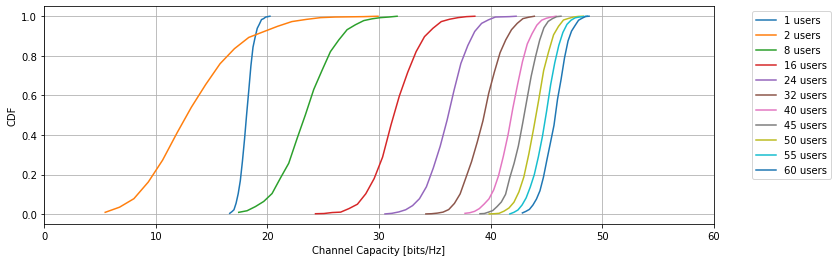

In [36]:
plt.figure(figsize=(12,4))
AVG = np.array([])
for i in range(len(us)):
    C = np.zeros(mc)
    for j in range(mc):
        np.random.seed(j)
        C[j] = sem_mc(us[i], N, BS, P_dBm)
    CDF, PDF, BINS = cdf(C)
    #AVG = np.append(AVG, avg)
    label = ('{} users'.format(us[i]))
    plt.plot(BINS[1::], CDF, label=label)
    #print("n - " + str(us[i]))
plt.ylabel("CDF")
plt.xlabel("Channel Capacity [bits/Hz]")
plt.xlim(0,60)
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.grid()

In [37]:
def cdf(C):
    C = np.sort(C)
    average_C = np.mean(C)
    std_C = np.std(C)
    cdf_C = norm.cdf(C, loc=average_C, scale=std_C)
    return cdf_C, average_C

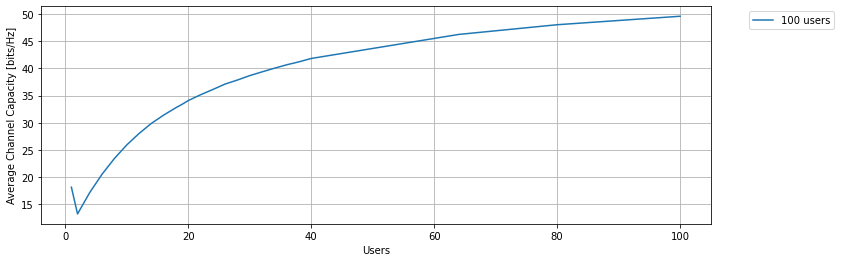

In [38]:
plt.figure(figsize=(12,4))
AVG = np.array([])
for i in range(len(n)):
    C = np.zeros(mc)
    for j in range(mc):
        np.random.seed(j)
        C[j] = sem_mc(n[i], N, BS, P_dBm)
    CDF, avg = cdf(C)
    AVG = np.append(AVG, avg)
    label = ('{} users'.format(n[i]))
    #print("n - " + str(n[i]))
plt.plot(n, AVG, label=label)
plt.ylabel("Average Channel Capacity [bits/Hz]")
plt.xlabel("Users")
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.grid()

### Percentile

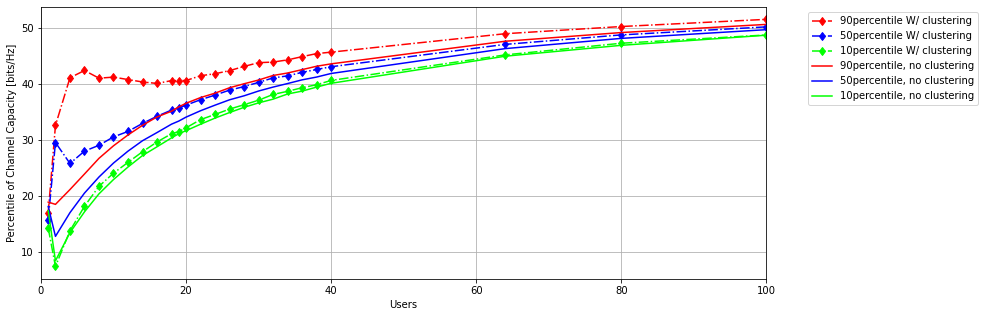

In [30]:
plt.figure(figsize=(13,5))
color = ['red','blue','lime']
n_percentile = ['90','50','10']

#With clustering
percentile_C = np.array([])
for i in range(len(n)):
    C = np.zeros(mc)
    for j in range(mc):
        np.random.seed(j)
        C[j] = sinr_mc(n[i], N, BS, P_dBm)
    percentile_C = np.append(percentile_C, [np.percentile(C,90),np.percentile(C,50),np.percentile(C,10)])
    #print("n - " + str(n[i]))
percentile_C = percentile_C.reshape(len(n),3).transpose()
#print('percentile_C : {}'.format(percentile_C))
for k in range(3):
    label = ('{}percentile W/ clustering'.format(n_percentile[k]))
    plt.plot(n, percentile_C[k], label=label,linestyle = '-.',marker = 'd',color=color[k])

#No clustering    
percentile_S = np.array([])
for i in range(len(n)):
    S = np.zeros(mc)
    for j in range(mc):
        np.random.seed(j)
        S[j] = sem_mc(n[i], N, BS, P_dBm)
    percentile_S = np.append(percentile_S, [np.percentile(S,90),np.percentile(S,50),np.percentile(S,10)])
    #print("n - " + str(n[i]))
percentile_S = percentile_S.reshape(len(n),3).transpose()
#print('percentile_S : {}'.format(percentile_S))
for k in range(3):
    label = ('{}percentile, no clustering'.format(n_percentile[k]))
    plt.plot(n, percentile_S[k], label=label, color=color[k])

plt.ylabel("Percentile of Channel Capacity [bits/Hz]")
plt.xlabel("Users")
plt.xlim(0,100)
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.grid()

# 3gpp channel model

def strVec(azmDeg,nAntennas,wavelength,d):
 
    ''' 
    This  functions calculates steering vector.
 
    azmDeg: set of angles that defines the angles of arrival (AoA) or angles of       departure (AoD)
    nAtennas  : Number of antennas
    wavelength: wavelength of the signal
    d         : spacing between antenna elements
 
    '''
 
    azmRad = azmDeg*(np.pi/180)
    
    n = (np.linspace(0,nAntennas-1,nAntennas))*d
    phase = (2*np.pi/wavelength)*np.outer(n,np.cos(azmRad))
 
    return np.exp(-1j*phase)
 
def covMtxGen(theta_medio_graus,espalhamento_angular_graus,numero_percursos,nAntennas):
 
    angles = np.random.rand(numero_percursos)*espalhamento_angular_graus + (theta_medio_graus - espalhamento_angular_graus/2)
 
    c = 3e8
    f = 2e9
    wavelength = c/f
    dist = wavelength
 
    V = 1/np.sqrt(nAntennas) * strVec(angles,nAntennas,wavelength,dist) 
    return V @ np.conjugate(V).transpose(), angles
    
 
# Exemplo
 
theta_medio_graus = 30 
espalhamento_angular_graus = 10
numero_percursos = 10
nAntennas = 5
 
R, theta = covMtxGen(theta_medio_graus,espalhamento_angular_graus,numero_percursos,nAntennas)
 
print(R)
print(theta)

In [16]:
def strVec(azmDeg,nAntennas,wavelength,d):
 
    ''' 
    This  functions calculates steering vector.
 
    azmDeg: set of angles that defines the angles of arrival (AoA) or angles of       departure (AoD)
    nAntennas  : Number of antennas
    wavelength: wavelength of the signal
    d         : spacing between antenna elements
 
    '''
 
    azmRad = azmDeg*(np.pi/180)
    
    n = (np.linspace(0,nAntennas-1,nAntennas))*d
    phase = (2*np.pi/wavelength)*np.outer(n,np.cos(azmRad))
 
    return np.exp(-1j*phase)
 
def covMtxGen(f,theta_medio_graus,espalhamento_angular_graus,numero_percursos,nAntennas):
 
    angles = np.random.rand(numero_percursos)*espalhamento_angular_graus + (theta_medio_graus - espalhamento_angular_graus/2)
 
    c = 3e8
    wavelength = c/f
    dist = wavelength
 
    V = 1/np.sqrt(nAntennas) * strVec(angles,nAntennas,wavelength,dist) 
    return V @ np.conjugate(V).transpose(), angles
    

def β_channel2(D, f):
    """
    Returns the pathloss
    """
    #Wavelength
    #λ = 3e8/f
    F = 4#*np.random.randn() #F~N(0,4²) is the shadow fading
    L_lin = inv_db(-30.5-36.7*np.log10(D)+F) 
    #Linear pathloss
    #F_lin = 2.51188643150958*np.random.randn() #inv_db(F)
    #L_lin = F_lin/(1122.018454301963 * D**(3.67))
    β = L_lin
    return β

def rand_channel2(R, N=5, angular_spread_degree=10, n_paths=2*N):
    """
    Returns the channel
    """
     #Carrier frequency (LTE band 7)
    f = 2.6e9 #Hz
    D = np.linalg.norm(R)
    β = β_channel2(D,f)
    ampl = np.sqrt(β)/2
    #Cartesian vector BS->UE
    x, y = R[0], R[1]
    #Azimutal direction BS->UE
    θ_med = np.arctan(y/x)
    
    angular_spread_degree = 10
    n_paths = 2*N
    nAntennas = N
    #Covariance matrix
    cov, θ = covMtxGen(f,θ_med,angular_spread_degree,n_paths,nAntennas)
    h = ampl * cov**(1/2) @ (np.random.randn(N) + 1j*np.random.randn(N))
    return h

def channel_user3(num_ue,numBS,nAntennas,UEpos,BSpos,UEs_antenna, angular_spread_degree=10, n_paths=2*N):
    """
    Retorna uma matriz 3D, onde h[UE][BS]{stream}
    """
    H = np.zeros((num_ue,numBS,nAntennas),dtype=complex)

    for i in range(numBS):
        for j in range(UEs_antenna[i].shape[0]):
            user = np.argmin(np.sum(np.abs(UEs_antenna[i][j] - UEpos),axis=1))
            R = BSpos[i] - UEs_antenna[i][j] 
            H[int(user)][i] = rand_channel2(R, nAntennas)
    return H

In [17]:
def sinr_mc2(num_ue, N, BS, P_dBm, angular_spread_degree, n_paths):
    """
    Gerar os canais, Com mesma BS e gerando diferentes UE calculando H,V,sinr e C()
    """
    total = BS.shape[0]
    UE = usuário(num_ue, 200, 100)
    UEs_antenna = UEs_per_BS(BS, UE, total)
    P_dBm = powerUE(num_ue, total, UE,UEs_antenna, P_dBm)
    H = channel_user3(num_ue,total,N,UE,BS,UEs_antenna, angular_spread_degree, n_paths)
    H = vectorize(H, num_ue, total, N)
    V = get_beamforming(H, num_ue, total, P_dBm)
    S = np.zeros(len(UE))
    for i in range(len(UE)):
        S[i] = sinr(H[i], V, i, σ)
    C = np.sum(np.log2(S+1)) 
    return C

def sem_mc2(num_ue, N, BS, P_dBm, angular_spread_degree, n_paths):
    """
    Gerar os canais, Com mesma BS e gerando diferentes UE calculando H,V,sinr e C()
    """
    total = BS.shape[0]
    UE = usuário(num_ue, 200, 100)
    UEs_antenna = [UE,UE,UE,UE,UE,UE,UE,UE]
    P_dBm = powerUE(num_ue, total, UE,UEs_antenna, P_dBm)
    H = channel_user3(num_ue,total,N,UE,BS,UEs_antenna, angular_spread_degree, n_paths)
    H = vectorize(H, num_ue, total, N)
    V = get_beamforming(H, num_ue, total, P_dBm)
    S = np.zeros(len(UE))
    for i in range(len(UE)):
        S[i] = sinr(H[i], V, i, σ)
    C = np.sum(np.log2(S+1))  
    return C

### Percentile

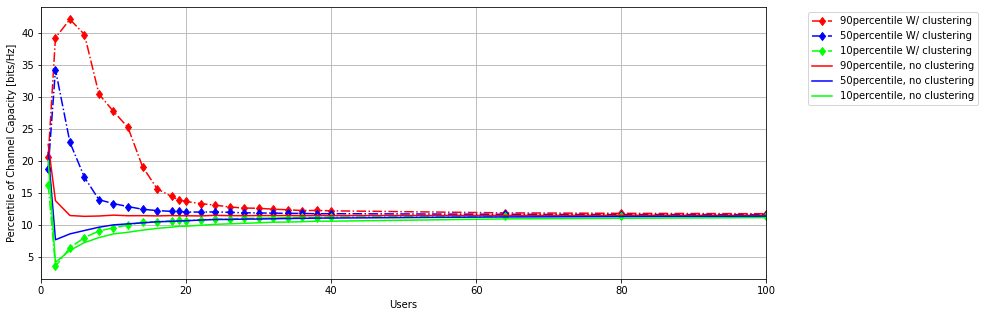

In [18]:
plt.figure(figsize=(13,5))
color = ['red','blue','lime']
n_percentile = ['90','50','10']
angular_spread_degree = 10
n_paths = 2*N

#With clustering
percentile_C = np.array([])
for i in range(len(n)):
    C = np.zeros(mc)
    for j in range(mc):
        np.random.seed(j)
        C[j] = sinr_mc2(n[i], N, BS, P_dBm, angular_spread_degree, n_paths)
    percentile_C = np.append(percentile_C, [np.percentile(C,90),np.percentile(C,50),np.percentile(C,10)])
    #print("n - " + str(n[i]))
percentile_C = percentile_C.reshape(len(n),3).transpose()
#print('percentile_C : {}'.format(percentile_C))
for k in range(3):
    label = ('{}percentile W/ clustering'.format(n_percentile[k]))
    plt.plot(n, percentile_C[k], label=label,linestyle = '-.',marker = 'd',color=color[k])

#No clustering    
percentile_S = np.array([])
for i in range(len(n)):
    S = np.zeros(mc)
    for j in range(mc):
        np.random.seed(j)
        S[j] = sem_mc2(n[i], N, BS, P_dBm, angular_spread_degree, n_paths)
    percentile_S = np.append(percentile_S, [np.percentile(S,90),np.percentile(S,50),np.percentile(S,10)])
    #print("n - " + str(n[i]))
percentile_S = percentile_S.reshape(len(n),3).transpose()
#print('percentile_S : {}'.format(percentile_S))
for k in range(3):
    label = ('{}percentile, no clustering'.format(n_percentile[k]))
    plt.plot(n, percentile_S[k], label=label, color=color[k])

plt.ylabel("Percentile of Channel Capacity [bits/Hz]")
plt.xlabel("Users")
plt.xlim(0,100)
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.grid()

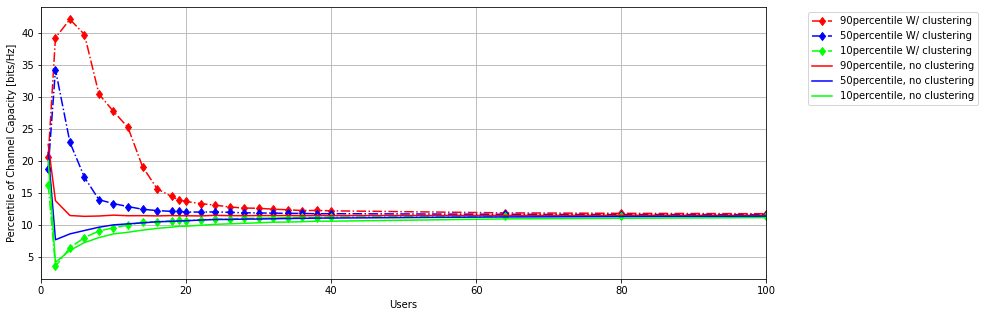

In [18]:
plt.figure(figsize=(13,5))
color = ['red','blue','lime']
n_percentile = 90
angular_spread_degree = [5,10,20]
n_paths = 2*N

#With clustering
percentile_C = np.array([])
for i in range(len(n)):
    C = np.zeros(mc)
    for j in range(mc):
        np.random.seed(j)
        C[j] = sinr_mc2(n[i], N, BS, P_dBm, angular_spread_degree, n_paths)
    percentile_C = np.append(percentile_C, np.percentile(C,n_percentile))
    #print("n - " + str(n[i]))
percentile_C = percentile_C.reshape(len(n),3).transpose()
#print('percentile_C : {}'.format(percentile_C))
for k in range(3):
    label = ('{}percentile W/ clustering'.format(n_percentile[k]))
    plt.plot(n, percentile_C[k], label=label,linestyle = '-.',marker = 'd',color=color[k])

#No clustering    
percentile_S = np.array([])
for i in range(len(n)):
    S = np.zeros(mc)
    for j in range(mc):
        np.random.seed(j)
        S[j] = sem_mc2(n[i], N, BS, P_dBm, angular_spread_degree, n_paths)
    percentile_S = np.append(percentile_S, [np.percentile(S,),np.percentile(S,50),np.percentile(S,10)])
    #print("n - " + str(n[i]))
percentile_S = percentile_S.reshape(len(n),3).transpose()
#print('percentile_S : {}'.format(percentile_S))
for k in range(3):
    label = ('{}percentile, no clustering'.format(n_percentile[k]))
    plt.plot(n, percentile_S[k], label=label, color=color[k])

plt.ylabel("Percentile of Channel Capacity [bits/Hz]")
plt.xlabel("Users")
plt.xlim(0,100)
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.grid()

### Ranging number of paths

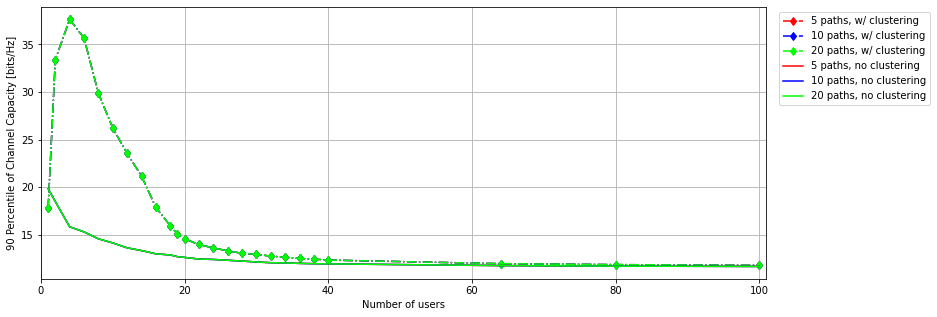

In [28]:
n_users = [1,2,4,6,8,10,12,14,16,18,19,20,22,24,26,28,30,32,34,36,38,40,64,80,100]

n_percentile = 90
angular_spread_degree = 10
max_paths = 4*N
n_paths = np.array([5,10,20])


color = ['red','blue','lime']
plt.figure(figsize=(13,5))
#With clustering
for n in range(len(n_paths)):
    percentile_C = np.array([])
    for n_user in n_users:
        C = np.zeros(mc)
        for j in range(mc):
            np.random.seed(j)
            C[j] = sinr_mc2(n_user, N, BS, P_dBm, angular_spread_degree, n_paths[n])
        percentile_C = np.append(percentile_C, np.percentile(C,n_percentile))
        #print("n user: " + str(n_user))
    label = '{} paths, w/ clustering'.format(n_paths[n])
    plt.plot(n_users, percentile_C, label=label,linestyle = '-.',marker = 'd', color=color[n])
    
#No clustering    
for n in range(len(n_paths)):
    percentile_S = np.array([])
    for n_user in n_users:
        S = np.zeros(mc)
        for j in range(mc):
            np.random.seed(j)
            S[j] = sem_mc2(n_user, N, BS, P_dBm, angular_spread_degree, n_paths[n])
        percentile_S = np.append(percentile_S, np.percentile(S,n_percentile))
        #print("n user: " + str(n_user))
    label = '{} paths, no clustering'.format(n_paths[n])
    plt.plot(n_users, percentile_S, label=label, color=color[n])    

plt.ylabel("{} Percentile of Channel Capacity [bits/Hz]".format(str(n_percentile)))
plt.xlabel("Number of users")
plt.xlim(0, n_user+1)
plt.legend(bbox_to_anchor=(1.01, 1.0), loc='upper left')
plt.grid()


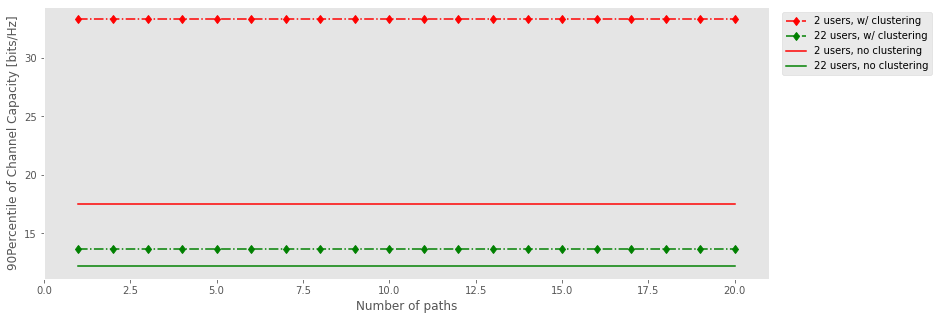

In [36]:
n_percentilen_users = [2,22]
n_percentile = 90
angular_spread_degree = 10
max_paths = 4*N
n_paths = np.arange(max_paths) + 1

color = ['red','green']
plt.figure(figsize=(13,5))
#With clustering
for n in range(len(n_users)):
    percentile_C = np.array([])
    for n_path in n_paths:
        C = np.zeros(mc)
        for j in range(mc):
            np.random.seed(j)
            C[j] = sinr_mc2(n_users[n], N, BS, P_dBm, angular_spread_degree, n_path)
        percentile_C = np.append(percentile_C, np.percentile(C,n_percentile))
        #print("n_paths - " + str(n_path))
    label = '{} users, w/ clustering'.format(n_users[n])
    plt.plot(n_paths, percentile_C, label=label,linestyle = '-.',marker = 'd', color=color[n])    
#No clustering    
for n in range(len(n_users)):
    percentile_S = np.array([])
    for n_path in n_paths:
        S = np.zeros(mc)
        for j in range(mc):
            np.random.seed(j)
            S[j] = sem_mc2(n_users[n], N, BS, P_dBm, angular_spread_degree, n_path)
        percentile_S = np.append(percentile_S, np.percentile(S,n_percentile))
        #print("n_paths - " + str(n_path))
    label = '{} users, no clustering'.format(n_users[n])
    plt.plot(n_paths, percentile_S, label=label, color=color[n])

plt.ylabel("{}Percentile of Channel Capacity [bits/Hz]".format(str(n_percentile)))
plt.xlabel("Number of paths")
plt.xlim(0, n_path+1)
plt.legend(bbox_to_anchor=(1.01, 1.0), loc='upper left')
plt.grid()


### With Least Square Beamforming

#### Centralized processing for all bases

In [19]:
def get_beamformingLScent(H):
    """
    Retorna o Least Square Beamforming normalizado de um canal h, onde v[UE][BS]{stream}
    """
    #h: Retorna uma matriz 3D, onde h[UE][BS]{stream}
    num_ue = np.size(H, axis=0)
    num_BS = np.size(H, axis=1)
    W = np.linalg.pinv(H).transpose()
    V = np.zeros_like(W,dtype='complex_')
    for k in range(len(V)):
        norm = np.linalg.norm(W[k])
        if norm != 0:
            V[k] = W[k]/norm
    return V

def sinrLS_mc(num_ue, N, BS, P_dBm):
    """
    Gerar os canais, Com mesma BS e gerando diferentes UE calculando H,V,sinr e C()
    """
    total = BS.shape[0]
    UE = usuário(num_ue, 200, 100)
    UEs_antenna = UEs_per_BS(BS, UE, total)
    P_dBm = powerUE(num_ue, total, UE,UEs_antenna, P_dBm)
    h = channel_user2(num_ue,total,N,UE,BS,UEs_antenna)
    #Power for clustering
    P = np.sqrt(inv_dbm(P_dBm))
    for k in range(num_ue):
        h[k] = P[k]*h[k]
    #Vectorizing channel: H[UE][BS*stream]
    H = vectorize(h, num_ue, total, N)
    V = get_beamformingLScent(H)
    S = np.zeros(len(UE))
    for i in range(len(UE)):
        S[i] = sinr(H[i], V, i, σ)
    C = np.sum(np.log2(S+1))  
    return C
def semLS_mc(num_ue, N, BS, P_dBm):
    """
    Gerar os canais, Com mesma BS e gerando diferentes UE calculando H,V,sinr e C()
    """
    total = BS.shape[0]
    UE = usuário(num_ue, 200, 100)
    UEs_antenna = [UE,UE,UE,UE,UE,UE,UE,UE]
    P_dBm = powerUE(num_ue, total, UE,UEs_antenna, P_dBm)
    h = channel_user2(num_ue,total,N,UE,BS,UEs_antenna)
    #Power for clustering
    P = np.sqrt(inv_dbm(P_dBm))
    for k in range(num_ue):
        h[k] = P[k]*h[k]
    #Vectorizing channel: H[UE][BS*stream]
    H = vectorize(h, num_ue, total, N)
    V = get_beamformingLScent(H)
    S = np.zeros(len(UE))
    for i in range(len(UE)):
        S[i] = sinr(H[i], V, i, σ)
    C = np.sum(np.log2(S+1))
    return C

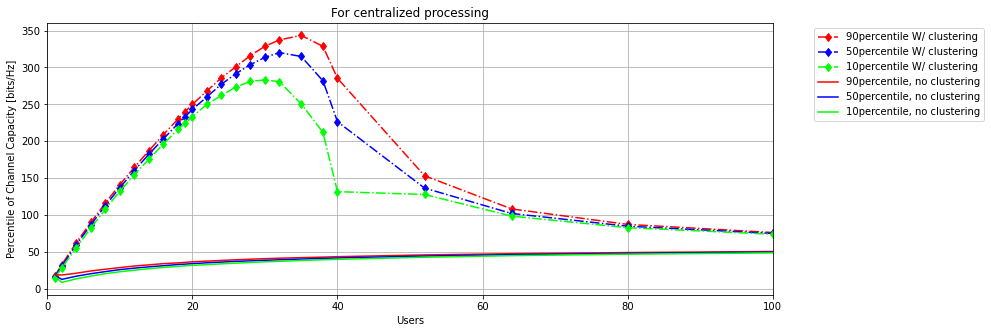

In [20]:
plt.figure(figsize=(13,5))
color = ['red','blue','lime']
n_percentile = ['90','50','10']
P_dBm = 40 #dBm

#With clustering
percentile_C = np.array([])
for i in range(len(n)):
    C = np.zeros(mc)
    for j in range(mc):
        np.random.seed(j)
        C[j] = sinrLS_mc(n[i], N, BS, P_dBm)
    percentile_C = np.append(percentile_C, [np.percentile(C,90),np.percentile(C,50),np.percentile(C,10)])
    #print("n - " + str(n[i]))
percentile_C = percentile_C.reshape(len(n),3).transpose()
#print('percentile_C : {}'.format(percentile_C))
for k in range(3):
    label = ('{}percentile W/ clustering'.format(n_percentile[k]))
    plt.plot(n, percentile_C[k], label=label,linestyle = '-.',marker = 'd',color=color[k])

#No clustering    
percentile_S = np.array([])
for i in range(len(n)):
    S = np.zeros(mc)
    for j in range(mc):
        np.random.seed(j)
        S[j] = sem_mc(n[i], N, BS, P_dBm)
    percentile_S = np.append(percentile_S, [np.percentile(S,90),np.percentile(S,50),np.percentile(S,10)])
    #print("n - " + str(n[i]))
percentile_S = percentile_S.reshape(len(n),3).transpose()
#print('percentile_S : {}'.format(percentile_S))
for k in range(3):
    label = ('{}percentile, no clustering'.format(n_percentile[k]))
    plt.plot(n, percentile_S[k], label=label, color=color[k])

plt.title("For centralized processing")
plt.ylabel("Percentile of Channel Capacity [bits/Hz]")
plt.xlabel("Users")
plt.xlim(0,100)
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.grid()

#### Distributed processing in each base

In [21]:
def get_beamformingLSdist(h):
    #Retorna o beamforming de um canal h, onde V[UE][BS]{stream}
    #h: Retorna uma matriz 3D, onde h[UE][BS]{stream}
    n_ue = np.size(h,axis=0)
    n_bs = np.size(h,axis=1)
    N = np.size(h,axis=2)
    
    H = np.zeros([n_bs,n_ue,N],dtype='complex_')
    for i in range(n_bs):
        for j in range (n_ue):
            H[i][j] = h[j][i]
    w = np.zeros([n_bs,n_ue,N],dtype='complex_')
    v = np.zeros([n_bs,n_ue,N],dtype='complex_')
    for k in range(n_bs):
        w[k] = np.linalg.pinv(H[k]).transpose()
        norm = np.linalg.norm(w[k])
        if norm != 0:
            v[k] = w[k]/norm
    
    #Finally, changing for V[UE][BS]{stream}
    V = np.zeros([n_ue,n_bs,N],dtype='complex_')
    for i in range(n_ue):
        for j in range (n_bs):
            V[i][j] = v[j][i]
    return V

def sinrLS_mc(num_ue, N, BS, P_dBm):
    """
    Gerar os canais, Com mesma BS e gerando diferentes UE calculando H,V,sinr e C()
    """
    total = BS.shape[0]
    UE = usuário(num_ue, 200, 100)
    UEs_antenna = UEs_per_BS(BS, UE, total)
    P_dBm = powerUE(num_ue, total, UE,UEs_antenna, P_dBm)
    h = channel_user2(num_ue,total,N,UE,BS,UEs_antenna)
    #Power for clustering
    P = np.sqrt(inv_dbm(P_dBm))
    for k in range(num_ue):
        h[k] = P[k]*h[k]
    #Vectorizing channel: H[UE][BS*stream]
    H = vectorize(h, num_ue, total, N)
    v = get_beamformingLSdist(h)
    V = vectorize(v, num_ue, total, N)
    S = np.zeros(len(UE))
    for i in range(len(UE)):
        S[i] = sinr(H[i], V, i, σ)
    C = np.sum(np.log2(S+1))  
    return C
def semLS_mc(num_ue, N, BS, P_dBm):
    """
    Gerar os canais, Com mesma BS e gerando diferentes UE calculando H,V,sinr e C()
    """
    total = BS.shape[0]
    UE = usuário(num_ue, 200, 100)
    UEs_antenna = [UE,UE,UE,UE,UE,UE,UE,UE]
    P_dBm = powerUE(num_ue, total, UE,UEs_antenna, P_dBm)
    h = channel_user2(num_ue,total,N,UE,BS,UEs_antenna)
    #Power for clustering
    P = np.sqrt(inv_dbm(P_dBm))
    for k in range(num_ue):
        h[k] = P[k]*h[k]
    #Vectorizing channel: H[UE][BS*stream]
    H = vectorize(h, num_ue, total, N)
    v = get_beamformingLSdist(h)
    V = vectorize(v, num_ue, total, N)
    S = np.zeros(len(UE))
    for i in range(len(UE)):
        S[i] = sinr(H[i], V, i, σ)
    C = np.sum(np.log2(S+1))
    return C

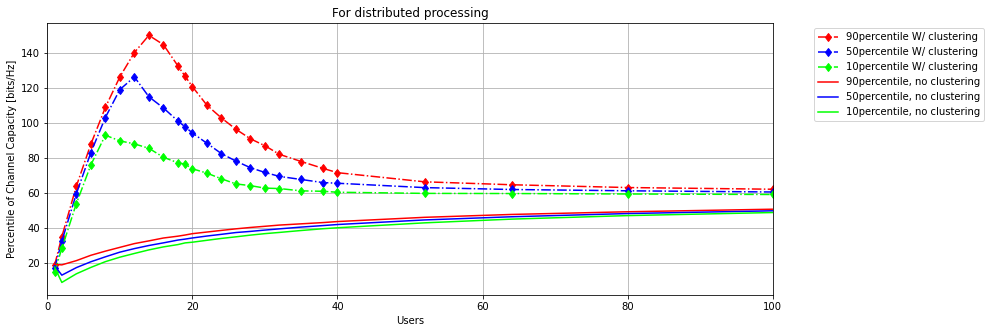

In [22]:
plt.figure(figsize=(13,5))
color = ['red','blue','lime']
n_percentile = ['90','50','10']
P_dBm = 40 #dBm

#With clustering
percentile_C = np.array([])
for i in range(len(n)):
    C = np.zeros(mc)
    for j in range(mc):
        np.random.seed(j)
        C[j] = sinrLS_mc(n[i], N, BS, P_dBm)
    percentile_C = np.append(percentile_C, [np.percentile(C,90),np.percentile(C,50),np.percentile(C,10)])
percentile_C = percentile_C.reshape(len(n),3).transpose()
for k in range(3):
    label = ('{}percentile W/ clustering'.format(n_percentile[k]))
    plt.plot(n, percentile_C[k], label=label,linestyle = '-.',marker = 'd',color=color[k])

#No clustering    
percentile_S = np.array([])
for i in range(len(n)):
    S = np.zeros(mc)
    for j in range(mc):
        np.random.seed(j)
        S[j] = sem_mc(n[i], N, BS, P_dBm)
    percentile_S = np.append(percentile_S, [np.percentile(S,90),np.percentile(S,50),np.percentile(S,10)])
percentile_S = percentile_S.reshape(len(n),3).transpose()
for k in range(3):
    label = ('{}percentile, no clustering'.format(n_percentile[k]))
    plt.plot(n, percentile_S[k], label=label, color=color[k])

plt.title("For distributed processing")
plt.ylabel("Percentile of Channel Capacity [bits/Hz]")
plt.xlabel("Users")
plt.xlim(0,100)
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.grid()